# Time series forecasting project

In [8]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression, LogisticRegression   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

## 1. Data loading

### 1.1. Load

In [9]:
raw_data_df=sns.load_dataset('flights')

### 1.2. Inspect 

In [10]:
raw_data_df.info()

print(raw_data_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB
   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [11]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [12]:
timeseries_df

,dependent_var
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [ ]:

linear_model=LinearRegression()


x=np.array(range(len(timeseries_df))).reshape(-1, 1)
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])
predictions=linear_model.predict(x)


timeseries_df['Linear model']=predictions


rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 45.7


### 2.2. Missing, and/or extreme values

            dependent_var  Linear model
date                                   
1949-01-01            112     90.309962
1949-02-01            118     92.967146
1949-03-01            132     95.624330
1949-04-01            129     98.281513
1949-05-01            121    100.938697
...                   ...           ...
1960-08-01            606    459.658525
1960-09-01            508    462.315709
1960-10-01            461    464.972893
1960-11-01            390    467.630077
1960-12-01            432    470.287261

[144 rows x 2 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

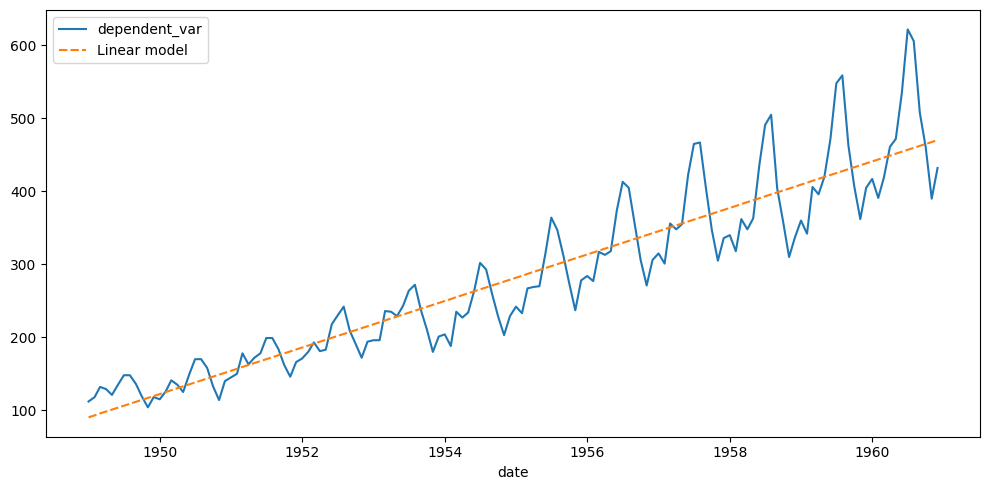

In [28]:
print(timeseries_df)
fig, axis = plt.subplots(figsize = (10,5,))

sns.lineplot(data = timeseries_df)

plt.tight_layout()
plt.show

In [34]:


print(timeseries_df.isnull().sum())


dependent_var    0
Linear model     0
dtype: int64


In [36]:
if timeseries_df.isnull().sum().sum() == 0:
    print("✅ No missing values in the entire DataFrame.")
else:
    print("⚠️ There are missing values.")
    

✅ No missing values in the entire DataFrame.


In [40]:
print(timeseries_df.describe())

       dependent_var  Linear model
count     144.000000    144.000000
mean      280.298611    280.298611
std       119.966317    110.839929
min       104.000000     90.309962
25%       180.000000    185.304286
50%       265.500000    280.298611
75%       360.500000    375.292936
max       622.000000    470.287261


### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular - i.e. are the rows evenly spaced in time.
2. Is the data stationary - i.e. is there a consistent trend over time. The answer to this question will effect how we model the data.
3. Are there regular or cyclical trends - e.g. sales are high on Mondays and low on weekends.

### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

In [12]:
# Plot the data over time and include the linear regression from above

### 2.3.2. Missing timepoints

In [43]:
# Take the difference across the datetime index
diff=np.diff(timeseries_df.index.to_numpy())

# Check that all of the differences are equal
equally_spaced=np.all(diff==diff[0])

print(f'Datetime axis is regular: {equally_spaced}\n')


Datetime axis is regular: False



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


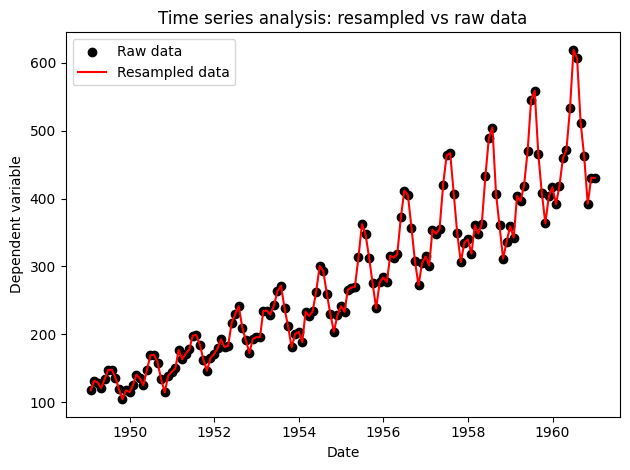

In [45]:

resampled_timeseries_df=timeseries_df.resample('D').interpolate()

# Then resample back up to months
resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
resampled_timeseries_df.info()


plt.title('Time series analysis: resampled vs raw data')
plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='black')
plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


timeseries_df=resampled_timeseries_df

### 2.3.4. Seasonality

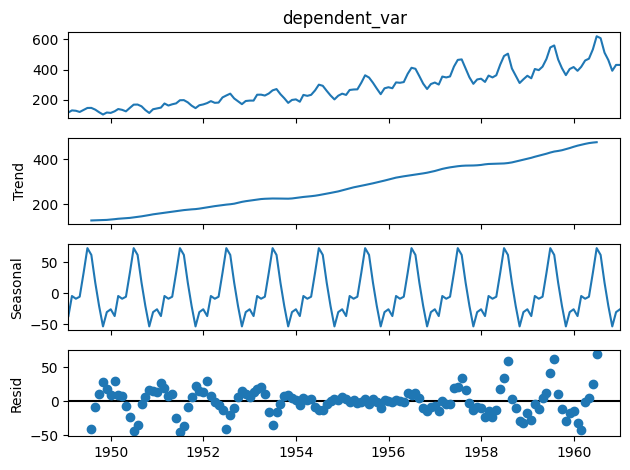

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure data is sorted by date
timeseries_df = timeseries_df.sort_index()

# Perform decomposition
decomposition = seasonal_decompose(timeseries_df['dependent_var'], period=12)

# Plot the decomposition
decomposition.plot()
plt.tight_layout()
plt.show()

In [75]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(timeseries_df['dependent_var'])

Dickey-Fuller test results:


Test Statistic                   0.473853
p-value                          0.984056
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

## 3. Model training

In [76]:
from pmdarima import auto_arima
model = auto_arima(timeseries_df['dependent_var'], seasonal = True, trace = True, m = 12)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1012.628, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1021.005, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1012.917, Time=0.11 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1013.833, Time=0.23 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1012.119, Time=0.88 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1011.298, Time=0.25 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1011.809, Time=0.92 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1016.507, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1016.547, Time=0.06 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,1,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=1012.999, Time=0.17 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1014.559, Time=0.04 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,0)[12]             : AIC=1010.846, Time=0.37 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,1,0)[12]             : AIC=1010.976, Time=0.68 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,1)[12]             : AIC=1011.283, Time=0.73 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,1,1)[12]             : AIC=1012.211, Time=1.20 sec
 ARIMA(0,1,3)(0,1,0)[12]             : AIC=1012.390, Time=0.05 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,1,0)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1015.209, Time=0.05 sec
 ARIMA(0,1,4)(0,1,0)[12]             : AIC=1012.747, Time=0.07 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,1,0)[12]             : AIC=1014.936, Time=0.37 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,0)[12] intercept   : AIC=inf, Time=0.40 sec

Best model:  ARIMA(1,1,3)(0,1,0)[12]          
Total fit time: 8.669 seconds


In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(1, 1, 3)x(0, 1, [], 12)   Log Likelihood                -500.423
Date:                             Mon, 24 Mar 2025   AIC                           1010.846
Time:                                     19:26:26   BIC                           1025.222
Sample:                                 01-31-1949   HQIC                          1016.687
                                      - 12-31-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7502      0.126      5.933      0.000       0.502       0.998
ma.L1         -1.0643      0.140     -7.583      0.000      -1.339      -0.789
ma.L2          0.2715      0.150      1.812      0.070      -0.022       0.565
ma.L3         -0.1861      0.127     -1.467      0.142      -0.435       0.063
sigma2       120.4694     13.459      8.951      0.000      94.091     146.848
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                16.44
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
forecast = model.predict(10)
forecast

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1961-01-31    410.435069
1961-02-28    438.197220
1961-03-31    483.252939
1961-04-30    497.825733
1961-05-31    561.099242
1961-06-30    648.686299
1961-07-31    637.193884
1961-08-31    542.657904
1961-09-30    494.677624
1961-10-31    424.862189
Freq: ME, dtype: float64

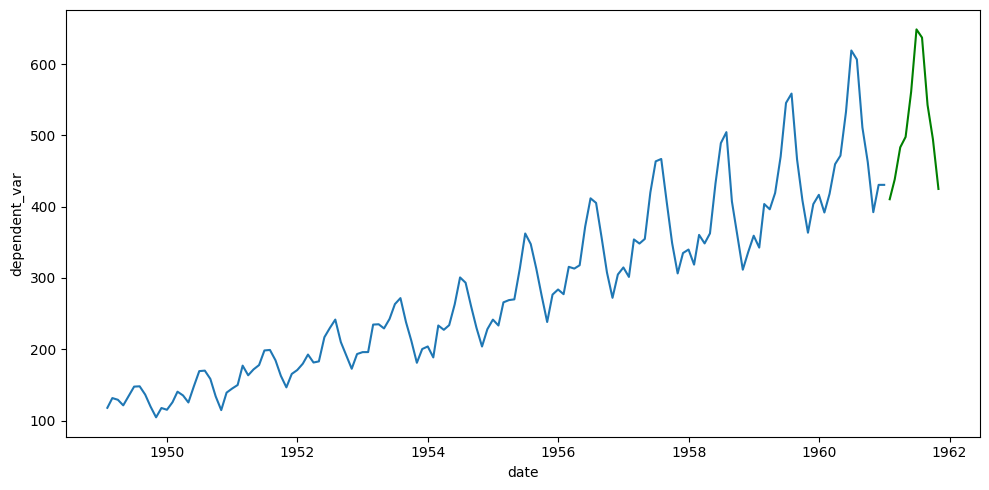

In [80]:


fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = timeseries_df['dependent_var'])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()


## 4. Model evaluation

This result *looks* convincing, at least if you don't look too closely - but how well are we actually doing? We need to implement train-test splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets because the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [ ]:
# I'll leave it up to you to try and figure out a good way to evaluate this model!